In [17]:
import pandas as pd
import re
from scipy.stats import chi2_contingency
from math import log, exp, sqrt
import gdown
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro  # Импортируем shapiro из scipy.stats
from scipy.stats import shapiro, levene  # Импортируем shapiro и levene из scipy.stats
from scipy.stats import mannwhitneyu  # Импортируем mannwhitneyu
from scipy import stats

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [18]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 0)
pd.set_option("display.max_colwidth", None)

In [19]:
file_id = '1BM7QmO4GoR5YxlMPfM5DLyrxBm3mn3oB'
dataset_link = f'https://drive.google.com/uc?id={file_id}'
output_file = 'after_eda_dataset.zip'

In [20]:
if not os.path.exists(output_file):
    gdown.download(dataset_link, output_file, quiet=False)
    print(f"Файл {output_file} скачан.")
else:
    print(f"Файл {output_file} уже существует.")

Файл after_eda_dataset.zip уже существует.


## Гипотеза 1

Разнофланговая рокировка открывает сторонам возможность одновременных пешечных штурмов — короли оказываются под встречными атаками, поэтому партии реже заканчиваются миром. Сформулируем гипотезы ...

- **H1**: Партии, где стороны рокировались в разные фланги, заканчиваются чаще результативно (win/lose), чем партии с одинаковой рокировкой.
- **H0**: Доли результативных партий в группах рокировавшихся в одну сторону и в разные стороны равны.

In [21]:
df = pd.read_csv(output_file, compression='zip')

In [22]:
# Убираем игры, где кол-во ходов было меньше 10.
# Т.е. игры по какой-либо причине закончившиеся слишком быстро
# Стоило бы это сделать на этапе EDA еще
df = df[(df["Num_Moves"] >= 10) & (df['Game_Duration'] >= 15)]

In [23]:
# Очищаем шахматные ходы (moves) от лишних знаков
# И создаем колонку - white_castle и black_castle - какую рокировку делали белые и черные.
def clean_move(move_str):
    return move_str.rstrip("+#?!")


def define_castle(moves_str, color):
    cl_df = re.sub(r"\{[^}]*\}", " ", moves_str)
    cl_df = re.sub(r"\d+\.", " ", cl_df)
    cl_df = re.sub(r"\s*(1-0|0-1|1/2-1/2)\s*$", " ", cl_df)
    cl_df = " ".join(cl_df.split())

    moves = cl_df.split(" ")
    if color == "white":
        rel_moves = [clean_move(m) for i, m in enumerate(moves) if i % 2 == 0]
    else:
        rel_moves = [clean_move(m) for i, m in enumerate(moves) if i % 2 == 1]

    for move in rel_moves:
        if move.startswith("O-O-O"):
            return "O-O-O"
        elif move.startswith("O-O"):
            return "O-O"
    return pd.NA


df["white_castle"] = df["Moves"].apply(lambda moves: define_castle(moves, "white"))
df["white_castle"].value_counts(dropna=False)

white_castle
O-O      84686
O-O-O    14173
<NA>     12978
Name: count, dtype: int64

In [8]:
df["black_castle"] = df["Moves"].apply(lambda moves: define_castle(moves, "black"))
df["black_castle"].value_counts(dropna=False)

black_castle
O-O      85909
<NA>     17573
O-O-O     8355
Name: count, dtype: int64

In [9]:
# Сравниваем рокировку белых и черных
def compare_castle(row):
    white, black = row["white_castle"], row["black_castle"]

    if pd.isna(white) or pd.isna(black):
        return "None"

    return "Same" if white == black else "Opposite"


df["castle_type"] = df.apply(compare_castle, axis=1)
df["castle_type"].value_counts()

castle_type
Same        73631
None        25918
Opposite    12288
Name: count, dtype: int64

In [10]:
# Создаем колонку - игра была результативная или ничейная
df["result_game"] = df["Winner"].apply(
    lambda x: "draw" if x == "draw" else "has_result")

Т.к. у нас обе переменные - рокировка и исход партии - категориальные и мы проверяем частотность распределения, поэтому применим $\chi^2$-тест Пирсона

In [11]:
records = []

# Проходимся по каждому speed_type 
# -> оставляем только игры, где были рокировки у обеих сторон
# -> создаем сопряженную таблицу с булевыми значениями
# -> вычисляем OR - отношение шансов
# -> проводим тест chi2, т.к. работаем с частотностью
# -> вычисляем доверительный интервал
# -> добавляем все результаты в один массив и создаем красивую таблицу для вывода
for speed_type, sub_df in df.groupby("Speed"):
    sub_df = sub_df[sub_df["castle_type"].isin(["Opposite", "Same"])]

    table = pd.crosstab(
        sub_df["castle_type"],
        sub_df["result_game"] == "has_result"
    ).reindex(
        index=["Opposite", "Same"],
        columns=[True, False],
        fill_value=0
    )

    opp_has_result, opp_draw = table.loc["Opposite"]
    same_has_result, same_draw = table.loc["Same"]

    odds_ratio = (opp_has_result * same_draw) / (opp_draw * same_has_result)
    se_log_or = sqrt(
        1/opp_has_result + 1/opp_draw + 1/same_has_result + 1/same_draw
    )
    ci_low = exp(log(odds_ratio) - 1.96 * se_log_or)
    ci_high = exp(log(odds_ratio) + 1.96 * se_log_or)

    _, p_value, _, _ = chi2_contingency(table, correction=False)

    records.append({
        "Speed": speed_type,
        "Opp_has_result": opp_has_result,
        "Opp_total":    opp_has_result + opp_draw,
        "Same_has_result": same_has_result,
        "Same_total":    same_has_result + same_draw,
        "OR": round(odds_ratio, 3),
        "CI_low": round(ci_low, 3),
        "CI_high": round(ci_high, 3),
        "p_value": p_value
    })

summary = pd.DataFrame(records)
summary

,Speed,Opp_has_result,Opp_total,Same_has_result,Same_total,OR,CI_low,CI_high,p_value
0,blitz,3293,3571,18947,21227,1.425,1.252,1.623,7.726398e-08
1,bullet,2609,2747,15520,16724,1.467,1.224,1.758,3.024523e-05
2,classical,2335,2572,12878,14848,1.507,1.308,1.737,1.161354e-08
3,rapid,2667,2913,16107,18449,1.576,1.374,1.809,6.480513e-11
4,ultraBullet,474,485,2323,2383,1.113,0.581,2.133,7.469061e-01


В форматах classical, rapid, blitz и bullet разница в исходах статистически значима (p-value < 0,05). Значит, можно уверенно сказать: когда игроки рокируются в разные стороны, партия чаще заканчивается победой одной из сторон, а не ничьёй.

В ultrabullet значимой разницы нет (p-value ≈ 0,75). Там почти каждая партия и так решается из-за жёсткого цейтнота, поэтому тип рокировки уже не влияет.

**Вывод:**

- В любых партиях от bullet до classical разнофланговая рокировка действительно делает исход более «боевым».

- В ultrabullet разницы нет, потому что почти все партии и так заканчиваются победой по времени.

## Гипотеза 2

В классических партиях допускают меньшее количество ошибок и неточностей, чем в блиц-партиях.

Нулевая гипотеза (H0): "В классических и блиц-партиях нет значимой разницы в количестве ошибок."

Альтернативная гипотеза (H1): "В классических партиях допускают меньшее количество ошибок и неточностей, чем в блиц-партиях."

Обоснование выбора данной гипотезы: 

Я решила проверить данную гипотезу, чтобы убедится в том, что игроки в классических партиях имеют возможность анализировать позиции без давления времени, что способствует снижению вероятности ошибок. В то время как в блиц-партиях стресс из-за ограниченного времени может негативно сказаться на качестве принятых решений. Я хотела выяснить влияет ли время, отведенное на размышления, на качество принятых решений. 

1. Подсчет общего числа ошибок и неточностей для белых и черных игроков.

In [12]:
df['Total_Errors'] = df['White_Inaccuracy'] + df['Black_Inaccuracy'] + df['White_Mistake'] + df['Black_Mistake'] + df['White_Blunder'] + df['Black_Blunder']

2. Проверка нормальности распределения

2.1. Построение гистограммы

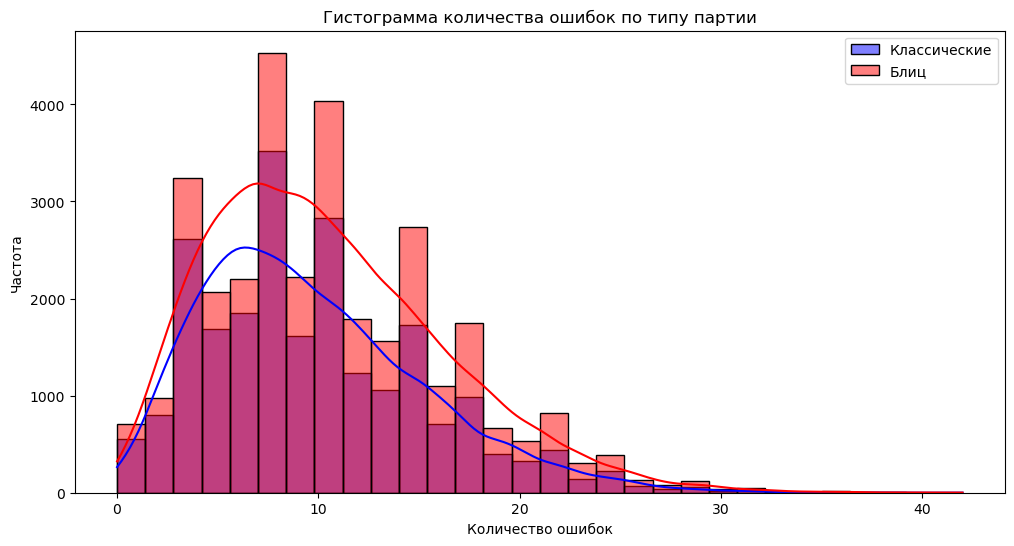

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['Speed'] == 'classical']['Total_Errors'], bins=30, color='blue', label='Классические', kde=True)
sns.histplot(df[df['Speed'] == 'blitz']['Total_Errors'], bins=30, color='red', label='Блиц', kde=True)
plt.legend()
plt.title('Гистограмма количества ошибок по типу партии')
plt.xlabel('Количество ошибок')
plt.ylabel('Частота')
plt.show()

Вывод: Судя по гистограмме, распределения количества ошибок в классических партиях и блице не являются нормальными.  Они скошены вправо (правосторонняя асимметрия),  имеют более длинный "хвост" справа от пика.  Нормальное распределение симметрично относительно среднего значения.

2.2. Построение Q-Q графиков

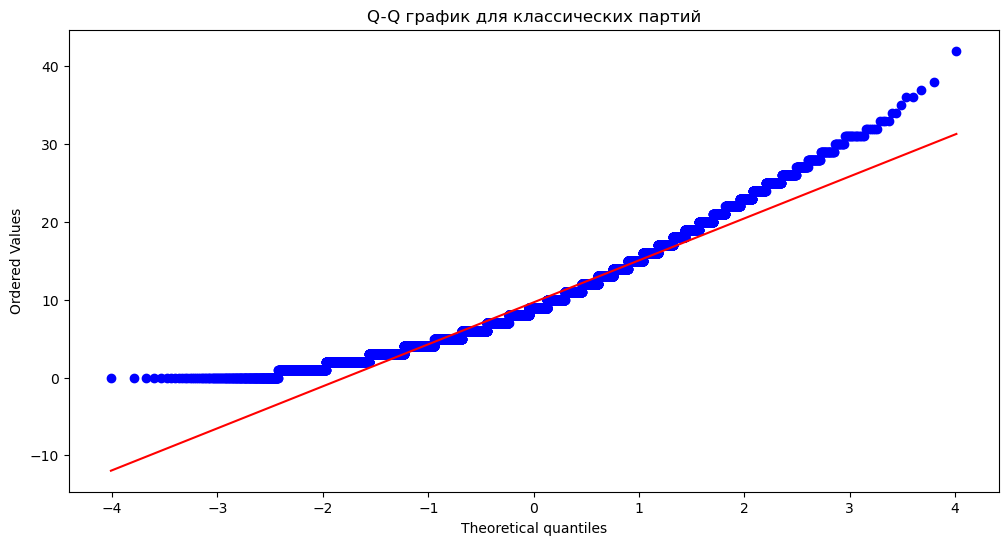

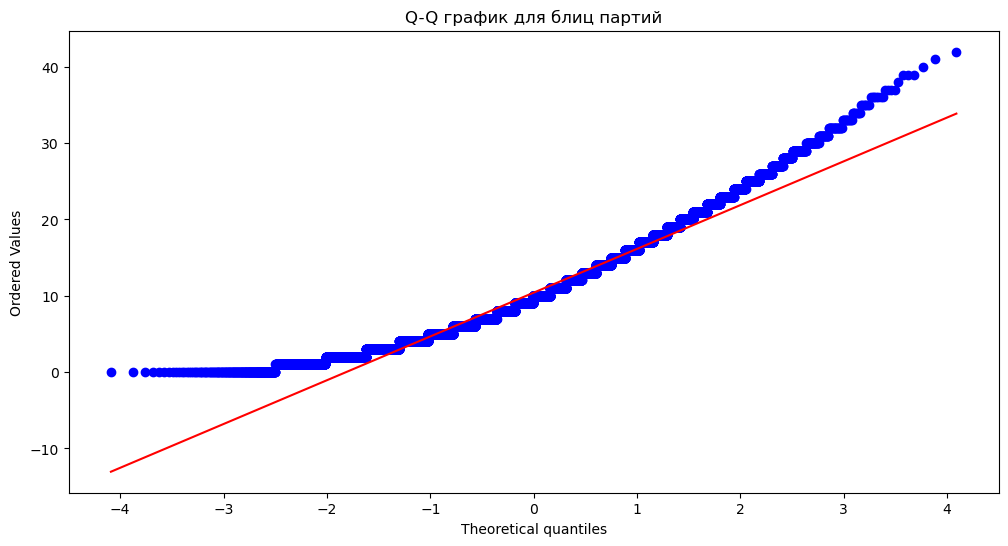

In [14]:
# Q-Q графики
plt.figure(figsize=(12, 6))
stats.probplot(df[df['Speed'] == 'classical']['Total_Errors'], dist="norm", plot=plt)
plt.title('Q-Q график для классических партий')
plt.show()

plt.figure(figsize=(12, 6))
stats.probplot(df[df['Speed'] == 'blitz']['Total_Errors'], dist="norm", plot=plt)
plt.title('Q-Q график для блиц партий')
plt.show()

Вывод: Распределения, представленные на Q-Q графиках, не является нормальными.  Отклонение синих точек от красной линии, особенно в правой части графиков, свидетельствует о наличии "тяжелого правого хвоста".  Это означает, что в данных присутствуют значения, значительно превышающие то, что ожидалось бы при нормальном распределении. Небольшое отклонение в левой части может указывать на  выбросы или асимметрию.

2.3. Тест Шапиро-Уилка

In [15]:
stat, p_value_classical = shapiro(df[df['Speed'] == 'classical']['Total_Errors'])
print('Классические партии: Статистика=%.3f, p-значение=%.3f' % (stat, p_value_classical))

stat, p_value_blitz = shapiro(df[df['Speed'] == 'blitz']['Total_Errors'])
print('Блиц партии: Статистика=%.3f, p-значение=%.3f' % (stat, p_value_blitz))

Классические партии: Статистика=0.955, p-значение=0.000
Блиц партии: Статистика=0.960, p-значение=0.000


c:\Users\Natasha\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22927.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Natasha\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32087.
  res = hypotest_fun_out(*samples, **kwds)


Вывод: оба p-значения равны 0.000, что значительно меньше стандартного уровня значимости 0.05. Это означает, что мы отвергаем нулевую гипотезу о нормальности распределения.

2.4. Тест Левена

In [16]:
stat, p_value = levene(df[df['Speed'] == 'classical']['Total_Errors'], df[df['Speed'] == 'blitz']['Total_Errors'])
print('Статистика Левена=%.3f, p-значение=%.3f' % (stat, p_value))

Статистика Левена=99.710, p-значение=0.000


Вывод:  значение 0.000 также значительно меньше 0.05, что указывает на то, что мы отвергаем нулевую гипотезу о равенстве дисперсий. Это означает, что дисперсии между классическими и блиц партиями статистически различны.

3. Выбор теста для проверки

Поскольку наши данные распределены ненормально, нам следует использовать непараметрические тесты, наиболее подходящим тестом будет тест Манна-Уитни (Mann-Whitney U test).

In [17]:
from scipy.stats import mannwhitneyu  # Импортируем mannwhitneyu

# Группировка данных по типу партии
classical_errors = df[df['Speed'] == 'classical']['Total_Errors']
blitz_errors = df[df['Speed'] == 'blitz']['Total_Errors']

# Применение теста Манна-Уитни
stat, p_value = mannwhitneyu(classical_errors, blitz_errors)

# Вывод результатов
print('Статистика Манна-Уитни=%.3f, p-значение=%.3f' % (stat, p_value))

# Интерпретация результатов
alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: есть значимая разница в количестве ошибок.")
else:
    print("Не можем отвергнуть нулевую гипотезу: нет значимой разницы в количестве ошибок.")


Статистика Манна-Уитни=341651558.000, p-значение=0.000
Отвергаем нулевую гипотезу: есть значимая разница в количестве ошибок.


Так как наше p_value равно 0.000, а это меньше чем 0.05,
следовательно, мы отвергаем нулевую гипотезу, т.е. мы доказали, что есть значимая разница в количестве ошибок между классикой и блицом.

Таким образом наша гипотеза (в классических партиях допускают меньшее количество ошибок и неточностей, чем в блиц-партиях) верна.

<h1>Гипотеза 3</h1>

Формулируем гипотезы:

Нулевая гипотеза (H0): Игра с сильнейшим противником не влияет на общее количество ошибок и неточностей.

Альтернативная гипотеза (H1): Игра с сильнейшим противником увеличивает общее количество ошибок и неточностей.

Предпосылки к гипотезе:

Гипотеза о том, что игрок совершает больше ошибок, играя против сильного соперника, базируется на психологических и поведенческих факторах. Игрок испытывает давление, столкнувшись с серьезным оппонентом. Стресс мешает концентрации внимания, снижает точность движений и принятие решений. Противник высокого уровня вызывает желание показать себя лучшим образом, из-за чего игрок может переоценивать риски, предпринимая рискованные действия или наоборот игроки боятся проиграть сильному сопернику и начинают играть чересчур осторожно, стараясь избегать рисков.Поэтому совершается больше ошибок.

In [8]:
# Создание общего числа ошибок для обоих игроков
df['Total_Errors_WHITE'] = df['White_Inaccuracy'] + df['White_Mistake'] + df['White_Blunder']
df['Total_Errors_BLACK'] = df['Black_Inaccuracy'] + df['Black_Mistake'] + df['Black_Blunder']

# Вычисляем разность рейтинга (белый игрок минус черный игрок)
df['Rating_Difference'] = abs(df['White_Rating'] - df['Black_Rating'])

# Выбор порога различия рейтингов для классификации "сильных противников"
rating_difference_threshold = 100

# Группируем матчи на основании разницы в рейтинге
strong_opponent_games = df[df['Rating_Difference'] >= rating_difference_threshold]
weak_or_average_opponent_games = df[df['Rating_Difference'] < rating_difference_threshold]

# Этап 3: Извлекаем суммарные ошибки для обеих групп (отдельно для черных и белых)
total_errors_strong_white = strong_opponent_games['Total_Errors_WHITE'].values
total_errors_strong_black = strong_opponent_games['Total_Errors_BLACK'].values

total_errors_weak_white = weak_or_average_opponent_games['Total_Errors_WHITE'].values
total_errors_weak_black = weak_or_average_opponent_games['Total_Errors_BLACK'].values

Проверка на нормальность распределения и расчет однородности дисперсии

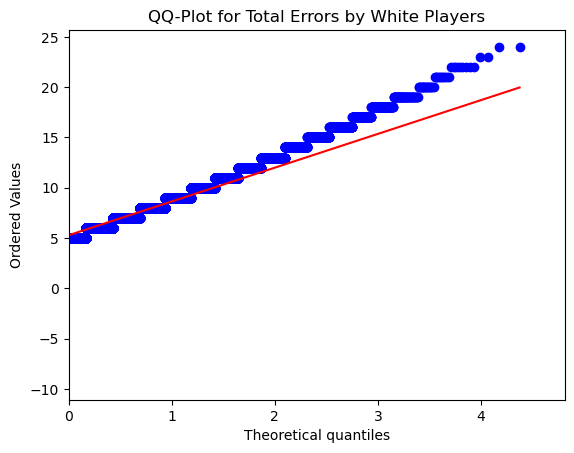

In [10]:
# Q-Q plot
stats.probplot(df['Total_Errors_WHITE'], dist="norm", plot=plt)
plt.xlim(left=0)
plt.title("QQ-Plot for Total Errors by White Players")
plt.show()

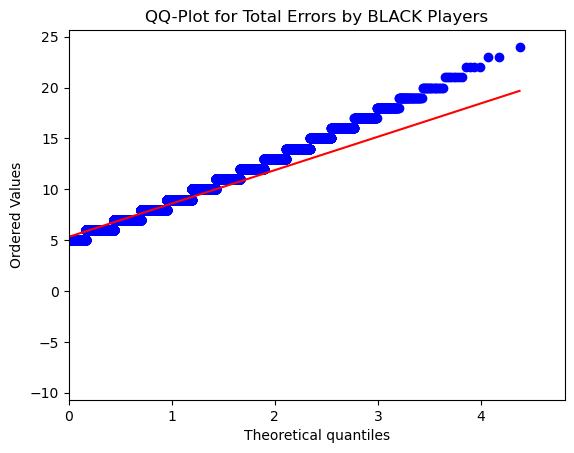

In [11]:
# Q-Q plot
stats.probplot(df['Total_Errors_BLACK'], dist="norm", plot=plt)
plt.xlim(left=0)
plt.title("QQ-Plot for Total Errors by BLACK Players")
plt.show()

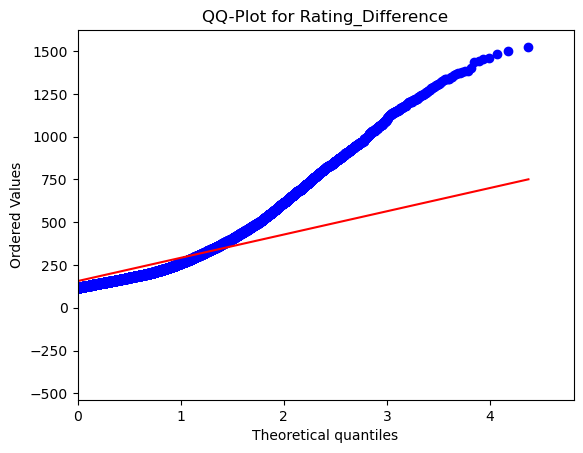

In [12]:
# Q-Q plot
stats.probplot(df['Rating_Difference'], dist="norm", plot=plt)
plt.xlim(left=0)
plt.title("QQ-Plot for Rating_Difference")
plt.show()

In [13]:
# Определение и проведение теста Колмогорова-Смирнова для белого цвета
ks_stat_white, ks_pval_white = stats.kstest(df['Total_Errors_WHITE'], 'norm')

# Определение и проведение теста Колмогорова-Смирнова для черного цвета
ks_stat_black, ks_pval_black = stats.kstest(df['Total_Errors_BLACK'], 'norm')

# Определение и проведение теста Колмогорова-Смирнова для черного цвета
ks_stat_Rating, ks_pval_Rating = stats.kstest(df['Rating_Difference'], 'norm')

# Выведем результаты
print(f"Критерий Колмогорова-Смирнова для белых:")
print(f"Статистика: {ks_stat_white:.4f}, P-значение: {ks_pval_white:.4f}")

print("\nКритерий Колмогорова-Смирнова для черных:")
print(f"Статистика: {ks_stat_black:.4f}, P-значение: {ks_pval_black:.4f}")
      
print("\nКритерий Колмогорова-Смирнова для рейтинга:")
print(f"Статистика: {ks_stat_Rating:.4f}, P-значение: {ks_pval_Rating:.4f}")   

Критерий Колмогорова-Смирнова для белых:
Статистика: 0.8397, P-значение: 0.0000

Критерий Колмогорова-Смирнова для черных:
Статистика: 0.8561, P-значение: 0.0000

Критерий Колмогорова-Смирнова для рейтинга:
Статистика: 0.9856, P-значение: 0.0000


In [14]:
variance_white_errors = df['Total_Errors_WHITE'].var(ddof=1)  # ddof=1 для выборочной дисперсии
variance_rating_difference = df['Rating_Difference'].var(ddof=1)
variance_black_errors = df['Total_Errors_BLACK'].var(ddof=1)

# Выводим результаты
print(f"Дисперсия Total_Errors_WHITE: {variance_white_errors:.4f}")
print(f"Дисперсия Rating_Difference: {variance_rating_difference:.4f}")
print(f"Дисперсия Total_Errors_BLACK: {variance_black_errors:.4f}")

Дисперсия Total_Errors_WHITE: 11.7629
Дисперсия Rating_Difference: 23679.6999
Дисперсия Total_Errors_BLACK: 11.2188


Данные не являются нормально распределенными и дисперсии не равны, поэтому используем U-критерий Манна-Уитни.

In [15]:
# Применяем U-критерий Манна-Уитни для белых игроков
statistic, p_value = mannwhitneyu(total_errors_strong_white, total_errors_weak_white, alternative='greater')

# Выводим результаты
print(f"U-statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Интерпретация результатов
alpha = 0.05  # уровень значимости
if p_value < alpha:
    print("Отвергнута нулевая гипотеза: существует значимая разница в количестве ошибок.")
    print("Выводы: Игра с сильнейшим противником увеличивает количество ошибок.")
else:
    print("Нулевая гипотеза не отвергнута: доказательств влияния силы соперника на увеличение ошибок недостаточно.")

U-statistic: 1546952230.0000
P-value: 0.9775
Нулевая гипотеза не отвергнута: доказательств влияния силы соперника на увеличение ошибок недостаточно.


In [16]:
# Применяем U-критерий Манна-Уитни для черных игроков
statistic, p_value = mannwhitneyu(total_errors_strong_black, total_errors_weak_black, alternative='greater')

# Выводим результаты
print(f"U-statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Интерпретация результатов
alpha = 0.05  # уровень значимости
if p_value < alpha:
    print("Отвергнута нулевая гипотеза: существует значимая разница в количестве ошибок.")
    print("Выводы: Игра с сильнейшим противником увеличивает количество ошибок.")
else:
    print("Нулевая гипотеза не отвергнута: доказательств влияния силы соперника на увеличение ошибок недостаточно.")

U-statistic: 1537265774.5000
P-value: 0.9999
Нулевая гипотеза не отвергнута: доказательств влияния силы соперника на увеличение ошибок недостаточно.


ВЫВОД:

По нашему тесту видно, что не существует прямой зависимости между силой игрока и количеством допускаемых ошибок при игре с ним при любой разнице в рейтинге.